1) Check out the Jupyter notebook for Chapter 8 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter08_intro-to-dl-for-computer-vision.ipynb. It uses the convolutional base of VGG16 for an image classification task, and also tries fine tuning. Your task: use another existing trained neural network (which is different from VGG16, such as ResNet) for the same task, and also try fine tuning. Submit your complete code, draw figures on the training/validation performance, and show the testing performance.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

### Downloading the data

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tian1001","key":"467bcb063412ea2ac6b2e388e8a7d36d"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 99% 808M/812M [00:03<00:00, 220MB/s]
100% 812M/812M [00:03<00:00, 232MB/s]


In [7]:
!unzip -qq dogs-vs-cats.zip

In [8]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the ResNet50 convolutional base**

In [24]:
conv_base = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [25]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

#### Fast feature extraction without data augmentation

**Extracting the ResNet50 features and corresponding labels**

In [60]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.resnet50.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [61]:
train_features.shape

(2000, 6, 6, 2048)

**Defining and training the densely connected classifier**

In [62]:
inputs = keras.Input(shape=(6, 6, 2048))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 3s 35ms/step - loss: 12.8052 - accuracy: 0.9330 - val_loss: 2.9585 - val_accuracy: 0.9710
Epoch 2/20
63/63 [==============================] - 2s 32ms/step - loss: 1.6082 - accuracy: 0.9845 - val_loss: 2.7499 - val_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 2s 24ms/step - loss: 2.0783 - accuracy: 0.9840 - val_loss: 4.2781 - val_accuracy: 0.9710
Epoch 4/20
63/63 [==============================] - 2s 25ms/step - loss: 1.0759 - accuracy: 0.9865 - val_loss: 3.6910 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 2s 25ms/step - loss: 0.1327 - accuracy: 0.9975 - val_loss: 3.0754 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 2s 25ms/step - loss: 0.8082 - accuracy: 0.9930 - val_loss: 8.9730 - val_accuracy: 0.9610
Epoch 7/20
63/63 [==============================] - 2s 25ms/step - loss: 0.1173 - accuracy: 0.9980 - val_loss: 3.7334 - val_accuracy: 0.9760
Epoch 8/20
6

**Plotting the results**

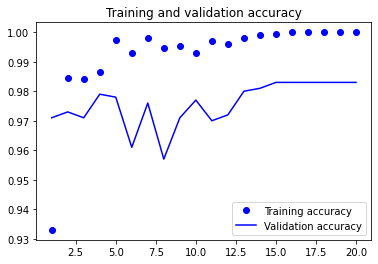

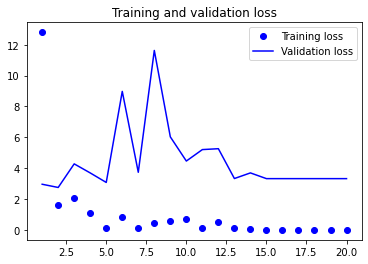

In [63]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [64]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 11s 154ms/step - loss: 2.8345 - accuracy: 0.9820
Test accuracy: 0.982


#### Feature extraction together with data augmentation

**Instantiating and freezing the ResNet50 convolutional base**

In [43]:
conv_base  = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [44]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 212


In [45]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [46]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 25s 305ms/step - loss: 16.5135 - accuracy: 0.9135 - val_loss: 3.0183 - val_accuracy: 0.9700
Epoch 2/20
63/63 [==============================] - 17s 271ms/step - loss: 5.8403 - accuracy: 0.9565 - val_loss: 6.2160 - val_accuracy: 0.9710
Epoch 3/20
63/63 [==============================] - 17s 270ms/step - loss: 5.4688 - accuracy: 0.9600 - val_loss: 15.7202 - val_accuracy: 0.9400
Epoch 4/20
63/63 [==============================] - 18s 284ms/step - loss: 5.2776 - accuracy: 0.9655 - val_loss: 2.7580 - val_accuracy: 0.9800
Epoch 5/20
63/63 [==============================] - 18s 285ms/step - loss: 4.8663 - accuracy: 0.9715 - val_loss: 2.1972 - val_accuracy: 0.9840
Epoch 6/20
63/63 [==============================] - 17s 270ms/step - loss: 2.7976 - accuracy: 0.9740 - val_loss: 3.1179 - val_accuracy: 0.9800
Epoch 7/20
63/63 [==============================] - 17s 272ms/step - loss: 3.5858 - accuracy: 0.9720 - val_loss: 3.2959 - val_accuracy: 0.98

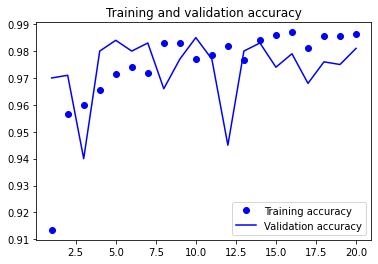

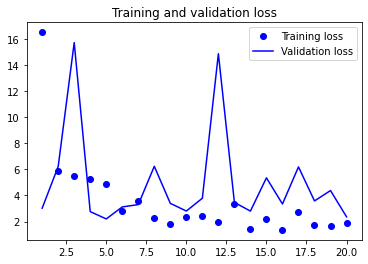

In [48]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [49]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 11s 154ms/step - loss: 2.8345 - accuracy: 0.9820
Test accuracy: 0.982


### Fine-tuning a pretrained model

In [50]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_11[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

**Freezing all layers until the fourth from the last**

In [51]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))
for layer in conv_base.layers[:-4]:
    layer.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 212
This is the number of trainable weights after freezing the conv base: 4


**Fine-tuning the model**

In [52]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
63/63 [==============================] - 26s 310ms/step - loss: 0.7058 - accuracy: 0.9905 - val_loss: 2.3283 - val_accuracy: 0.9810
Epoch 2/5
63/63 [==============================] - 19s 291ms/step - loss: 0.7234 - accuracy: 0.9915 - val_loss: 2.2561 - val_accuracy: 0.9810
Epoch 3/5
63/63 [==============================] - 18s 276ms/step - loss: 0.5718 - accuracy: 0.9920 - val_loss: 2.2845 - val_accuracy: 0.9820
Epoch 4/5
63/63 [==============================] - 18s 277ms/step - loss: 0.4359 - accuracy: 0.9940 - val_loss: 2.3773 - val_accuracy: 0.9820
Epoch 5/5
63/63 [==============================] - 18s 276ms/step - loss: 0.5150 - accuracy: 0.9930 - val_loss: 2.5386 - val_accuracy: 0.9810


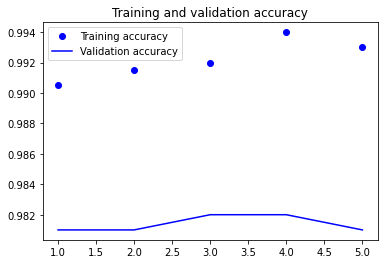

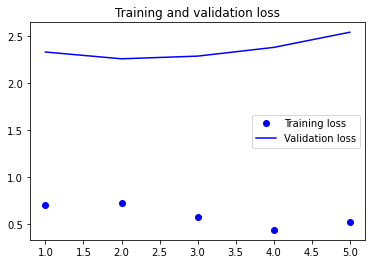

In [53]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [54]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 11s 157ms/step - loss: 3.3194 - accuracy: 0.9785
Test accuracy: 0.979
